<a href="https://colab.research.google.com/github/Danzigerrr/PyTorch-Practice/blob/Convolutional-Neural-Network-1/Convolutional_Neural_Network_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network model

Data - MNIST dataset

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data

convert images to tensore of 4-dimenstions (images, height, widht, colour)

In [2]:
transform = transforms.ToTensor()


#### Test data

In [3]:
train_data = datasets.MNIST(root = '/cnn_data', train = True, download = True, transform = transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

#### Test data

In [5]:
test_data = datasets.MNIST(root = '/cnn_data', train = False, download = True, transform = transform)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

See where the data is saved

In [7]:
cd ../

/


In [8]:
ls

bin@                        datalab/  lib32@   NGC-DL-CONTAINER-LICENSE  root/  tmp/
boot/                       dev/      lib64@   opt/                      run/   tools/
cnn_data/                   etc/      libx32@  proc/                     sbin@  usr/
content/                    home/     media/   python-apt/               srv/   var/
cuda-keyring_1.0-1_all.deb  lib@      mnt/     python-apt.tar.xz*        sys/


In [9]:
cd cnn_data

/cnn_data


In [10]:
ls

MNIST/


In [11]:
cd ../

/


In [12]:
cd content

/content


## Train model

### Data loaders

In [13]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

### Define CNN Workflow (step by step)

In [14]:
conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, stride = 1)
conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3, stride = 1)

In [15]:
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [16]:
X_Train.shape

torch.Size([1, 28, 28])

In [17]:
x = X_Train.view(1,1,28,28)

In [18]:
# 1st convolution layer
x = F.relu(conv1(x))

In [19]:
# 1 channel (greyscale), 6 filters, 26x26 image size (output; no padding used)
x.shape

torch.Size([1, 6, 26, 26])

In [20]:
# pooling layer (kernel of 2, stride of 2)
x = F.max_pool2d(x, 2, 2)

In [21]:
x.shape

torch.Size([1, 6, 13, 13])

In [22]:
# 2nd convolution layer
x = F.relu(conv2(x))

In [23]:
# 1 channel (greyscale), 16 filters, 11x11 image size (output; no padding used)
x.shape

torch.Size([1, 16, 11, 11])

In [24]:
x = F.max_pool2d(x, 2, 2)

In [25]:
# 1 channel (greyscale), 16 filters, 5x5 image size (output; no padding used)
x.shape

torch.Size([1, 16, 5, 5])

## Define Model Class

In [31]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    # conv layers
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # fully connected neural layer
    self.fc1 = nn.Linear(5*5*16, 120)  # 5x5 - size of output image from the last conv layer
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)  # 10 - number of classes in the datasets (digits 0-9)

  def forward(self, x):
    # conv layer 1
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)  # kernel of 2x2, stride of 2

    # conv layer 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)  # kernel of 2x2, stride of 2

    # re-view the data to flatten it out
    x = x.view(-1, 5*5*16)  # we use -1 so that we can vary the batch size

    # fully connected neural layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim = 1)

In [32]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Loss Function Optimizer

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

## Train CNN Model

In [51]:
import time
start_time = time.time()

# Create Variables To Track Things
epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1  # start our batches at 1
        y_pred = model(X_train)  # get predicted values from the training set (2d output)
        loss = criterion(y_pred, y_train)  # calculate the loss (how off are we?)

        # Calculate the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]  # get the index of the max log-probability
        batch_corr = (predicted == y_train).sum()  # how many we got correct in this batch
        trn_corr += batch_corr  # accumulate correct predictions

        # Update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results every 600 batches
        if b % 600 == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # Test (validation)
    model.eval()  # Set model to evaluation mode (no gradients required)
    val_loss = 0
    val_corr = 0
    with torch.no_grad():  # No gradient so we don't update our weights and biases with test data
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss = criterion(y_val, y_test)  # compute the validation loss
            val_loss += loss.item()  # accumulate the validation loss

            predicted = torch.max(y_val.data, 1)[1]  # Adding up correct predictions
            val_corr += (predicted == y_test).sum()  # sum up the correct predictions

    val_loss /= len(test_loader)  # Average the validation loss over all batches
    test_losses.append(val_loss)
    test_correct.append(val_corr)

    print(f'Epoch {i+1}: Train accuracy: {trn_corr / len(train_loader.dataset)}, '
          f'Test accuracy: {val_corr / len(test_loader.dataset)}')

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total / 60} minutes!')


Epoch: 0  Batch: 600  Loss: 3.6835494938713964e-06
Epoch: 0  Batch: 1200  Loss: 0.0041022999212145805
Epoch: 0  Batch: 1800  Loss: 0.00012332404730841517
Epoch: 0  Batch: 2400  Loss: 0.001058673718944192
Epoch: 0  Batch: 3000  Loss: 0.45169076323509216
Epoch: 0  Batch: 3600  Loss: 0.00964687392115593
Epoch: 0  Batch: 4200  Loss: 6.611419667024165e-05
Epoch: 0  Batch: 4800  Loss: 6.651684088865295e-06
Epoch: 0  Batch: 5400  Loss: 4.1217688703909516e-05
Epoch: 0  Batch: 6000  Loss: 0.0010278036352247
Epoch 1: Train accuracy: 0.9946333169937134, Test accuracy: 0.9883999824523926
Epoch: 1  Batch: 600  Loss: 0.1679043024778366
Epoch: 1  Batch: 1200  Loss: 3.9295682654483244e-05
Epoch: 1  Batch: 1800  Loss: 8.3325503510423e-06
Epoch: 1  Batch: 2400  Loss: 0.00010772183304652572
Epoch: 1  Batch: 3000  Loss: 6.482900062110275e-05
Epoch: 1  Batch: 3600  Loss: 0.002151269931346178
Epoch: 1  Batch: 4200  Loss: 7.390956966446538e-07
Epoch: 1  Batch: 4800  Loss: 1.704687747405842e-06
Epoch: 1  Batc

### Graph Loss at Each Epoch

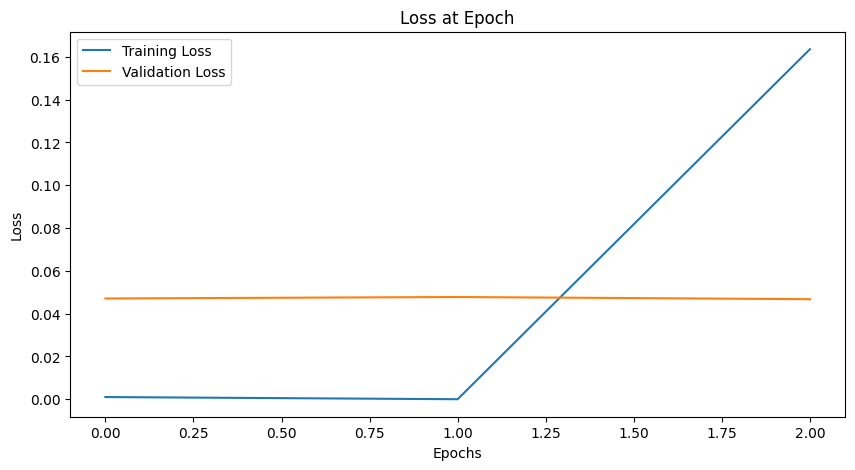

In [58]:
# Graph the loss at epoch
train_losses = [tl for tl in train_losses]  # Ensure losses are in the proper format
test_losses = [tl for tl in test_losses]  # Ensure test losses are in the proper format
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Accuracy at the End of Each Epoch

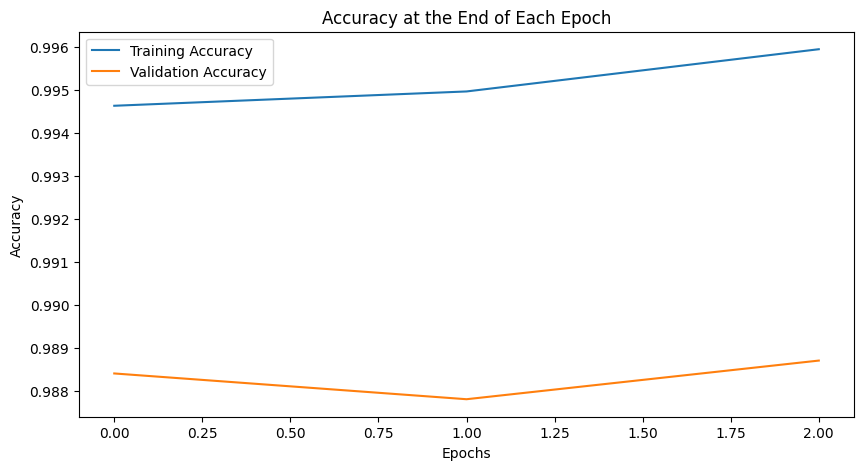

In [59]:
# Graph the accuracy at the end of each epoch
train_accuracy = [t / len(train_loader.dataset) for t in train_correct]  # Normalize by dataset size
test_accuracy = [t / len(test_loader.dataset) for t in test_correct]  # Normalize by dataset size
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Validation Accuracy")
plt.title("Accuracy at the End of Each Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Test Trained Model

In [60]:
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [62]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [65]:
print(f'Test accuracy: {correct / len(test_data)*100}%')

Test accuracy: 98.8699951171875%


## Send an Image through the Trained Model

### Take an image from the dataset

In [73]:
index_of_image = 19
image_to_classify = test_data[index_of_image][0]
image_to_classify.reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

### Show the image

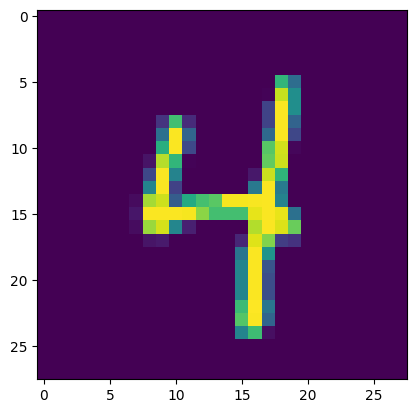

In [74]:
plt.imshow(image_to_classify.reshape(28,28))

### Pass image into the model

In [76]:
model.eval()
with torch.no_grad():
  new_prediction = model(image_to_classify.view(1,1,28,28))

In [82]:
predicted_class = new_prediction.argmax().item()
print(f'The model predicts that this digit is a {predicted_class}')

The model predicts that this digit is a 4
